In [28]:
import sys, os
import imp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0,'./lib')
import sims_reader as timean
import timeit
import glob
from sims_reader import (FileManager, MemoryReader, FilterList, Simulation, Sim0404)
from correlations import CorrelateTwoShears

In [29]:
def print_sims(path,param_filter):
    sims = {}
    print('| id | commit | Status | Nodes | Seed | Version | Template | Factor | Shear | Nside | Memory (GB) | Disk  | Time (s)| Preparation Date')
    print(' |:---:|:----:|:----:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:----:|:----:|')
 
    # Delete empty directories
    FileManager.remove_empty_dirs(path)

    # Find simulations
    for i,sim in enumerate(FileManager.get_simulations(path,param_filter)):
        simname = i
        sims[simname] = Sim0404(sim,simname)
    
    # Getting informations    
    for x in sims.keys():
        if sims[x].status == 'done': 
            sims[x].set_time_reader()
            
        sims[x].set_memory_reader()
        sims[x].set_size()
        sims[x].set_shear_reader()
        
    for sim in sims.items():#sorted(sims.items(), key = lambda x: ('0' if x[1].template=='master_with_shear' else x[1].__name__)):
        x = sim[1]
        total_time = round(x.time_reader.times["Total"]/1000 if x.status == 'done' else 0,4)
        print('| {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | {} |'.format(x.__name__,x.commit,x.status,x.nodes,x.seed,x.version,x.template,x.factor,x.shear,x.nside,x.memory_reader.tasks['Total']['Memory']/1000, x.size,total_time, x.preparation_time))
    return sims

In [3]:
import logging.config
logging.basicConfig(stream=sys.stdout, level=logging.WARNING)

In [4]:
path = "/global/cscratch1/sd/cramirez/CoLoRe_LSST/"

In [5]:
filt = {
    "status" : ["done"],
    "template": ["shear_test"],
    "factor" : [0]
}

sims = print_sims(path,filt)

| id | commit | Status | Nodes | Seed | Version | Template | Factor | Shear | Nside | Memory (GB) | Disk  | Time (s)| Preparation Date
 |:---:|:----:|:----:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:----:|:----:|
| 0 | 2005 | done | 10 | 1003 | New | shear_test | 0 | 50 | 512 | 3.354 | 290M | 2.8483 | 20200525035601 |
| 1 | None | done | 10 | 1003 | master | shear_test | 0 | None | None | 1.596 | 318M | 2.0673 | 20200416101437 |
| 2 | None | done | 1 | 1003 | master | shear_test | 0 | None | None | 1.568 | 318M | 3.7632 | 20200416101449 |
| 3 | 0404 | done | 10 | 1003 | Old | shear_test | 0 | 20 | 512 | 1.596 | 318M | 1.9141 | 20200416101416 |
| 4 | 2005 | done | 10 | 1003 | Old | shear_test | 0 | 50 | 512 | 1.596 | 290M | 2.0455 | 20200525035754 |
| 5 | 2005 | done | 10 | 1003 | Old | shear_test | 0 | 50 | 512 | 1.596 | 290M | 2.0163 | 20200525034124 |


In [6]:
new = sims[0]
old = sims[4]
master = sims[1]

In [39]:
old.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/Old/shear_50/nside_512/0/20200525035754'

In [40]:
master.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/master/0/20200416101437'

In [7]:
new_vals = new.shear_reader.get_values('mp_e1',compute=True)
old_vals = old.shear_reader.get_values('mp_e1',compute=True)
master_vals = master.shear_reader.get_values('mp_e1',compute=True)

In [8]:
new_vals/old_vals

<ipython-input-8-159782574253>:1: RuntimeWarning: invalid value encountered in true_divide
  new_vals/old_vals


array([3.46065294, 0.82499841, 1.09755302, ..., 0.68180964, 1.1161305 ,
       0.77726462])

In [9]:
old_vals/master_vals

<ipython-input-9-611806ce10c7>:1: RuntimeWarning: invalid value encountered in true_divide
  old_vals/master_vals


array([1., 1., 1., ..., 1., 1., 1.])

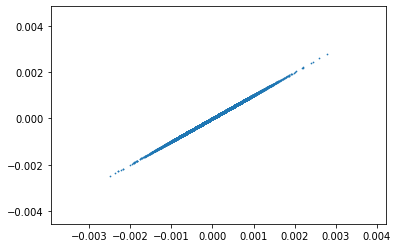

In [12]:
plt.scatter(old_vals,master_vals, s=0.5)
plt.show()

# CLS test

In [15]:
def plotpower(ld,values,labels=None, colors=None, lw=2,
              ylabel='$C_{\\ell \mathrm{new}}/C_{\\ell \mathrm{old}}$', 
              legend = False, legloc = "lower left", legframeon = False, leglabelspacing = 0.1, legncol = 2,
              xlim=[2,192], ylim = None,
               filename="", title ="",path_save_figures=""):
        
    plt.figure()
    if labels is None: labels = [''  for i in range(len(values))]
        
    if colors is not None:
        for i in range(len(values)):
            plt.plot(ld,values[i], colors[i]+'-', lw=lw,
                     label=labels[i])
    else:
        for i in range(len(values)):
            plt.plot(ld,values[i],lw=lw, label = labels[i])
    plt.xlabel('$\\ell$', fontsize=16)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if legend: plt.legend(loc=legloc, frameon=legframeon, labelspacing=leglabelspacing, ncol=legncol)
    if title != "":
        plt.title(title)
    if filename != "":
        plt.savefig(path_save_figures+filename+'.png',format='png')

In [16]:
cld_dd_string = '$\\delta_g\\times\\delta_g$'
cld_de_string = '$\\gamma^E_g\\times\\delta_g$'
cld_ee_string = '$\\gamma^E_g\\times\\gamma^E_g$'
cld_bb_string = '$\\gamma^B_g\\times\\gamma^B_g$'
cld_eb_string = '$\\gamma^E_g\\times\\gamma^B_g$'
cld_db_string = '$\\gamma^B_g\\times\\delta_g$'
cld_kd_string = '$\\kappa-\\delta_g$'
cld_kk_string = '$\\kappa-\\kappa$'
strings = ['cld_dd','cld_ee','cld_de','cld_bb']
labels = [cld_dd_string, cld_ee_string,cld_de_string,cld_bb_string]
colors = ['r','y','c','m']

In [30]:
new.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/New/shear_50/nside_512/0/20200525035601'

In [31]:
new.location

'/global/cscratch1/sd/cramirez/CoLoRe_LSST/New/shear_50/nside_512/0/20200525035601'

In [32]:
ld       = new.shear_reader.get_values('ld',source=1,compute=True)
values   = [new.shear_reader.get_values(string,source=1,compute=True)/old.shear_reader.get_values(string,source=1,compute=True) for string in strings]
values_1 = [old.shear_reader.get_values(string,source=1,compute=True)/master.shear_reader.get_values(string,source=1,compute=True) for string in strings]

<ipython-input-32-d048e1aa0bf7>:2: RuntimeWarning: invalid value encountered in true_divide
  values   = [new.shear_reader.get_values(string,source=1,compute=True)/old.shear_reader.get_values(string,source=1,compute=True) for string in strings]
<ipython-input-32-d048e1aa0bf7>:3: RuntimeWarning: invalid value encountered in true_divide
  values_1 = [old.shear_reader.get_values(string,source=1,compute=True)/master.shear_reader.get_values(string,source=1,compute=True) for string in strings]


In [ ]:
fig, ax = plt.subplots()

ax.plot()

(0.5, 1.5)

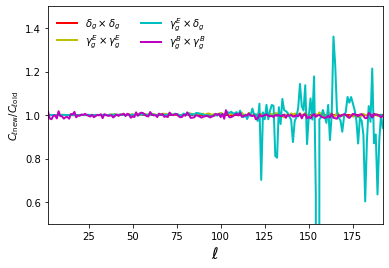

In [37]:
plotpower(ld,values,labels=labels,colors=colors,legend=True,legloc='upper left')
plt.ylim(0.5,1.5)

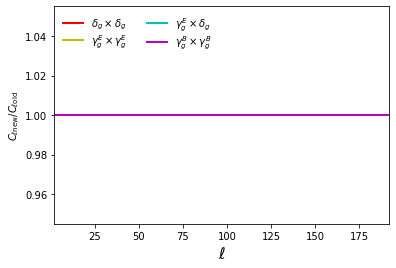

In [38]:
plotpower(ld,values_1,labels=labels,colors=colors,legend=True,legloc='upper left')